In [14]:
import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

In [17]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100
num_classes = 10

In [15]:
class Dataset:
    def __init__(self, num_labeled):
        self.num_labeled = num_labeled
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        
        def preprocess_imgs(x):
            x = (x.astype(np.float32) - 127.5) / 127.5
            x = np.expand_dims(x, axis = 3)
            return x
        
        def preprocess_labels(y):
            return y.reshape(-1, 1)
        
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)
        
    def batch_labeled(self, batch_size):
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels
    
    def batch_unlabeled(self, batch_size):
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
        imgs = self.x_train[idx]
        return imgs
    
    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train
    
    def test_set(self):
        return self.x_test, self.y_test

In [16]:
num_labeled=100
dataset = Dataset(num_labeled)

In [3]:
def build_generator(img_shape, z_dim):
    generator_input = Input(shape=(z_dim,), name = 'generator_input')
    x = generator_input
    x = Dense(256*7*7)(x)
    x = Reshape((7, 7, 256))(x)
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2DTranspose(64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same')(x)
    x = Activation('tanh', name='generator_output')(x)
    generator_output = x
    generator = Model(generator_input, generator_output, name = 'generator')
    return generator

In [4]:
generator = build_generator(img_shape, z_dim)

In [5]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        73

In [18]:
def build_discriminator(img_shape):
    discriminator_input = Input(shape=img_shape, name='discriminator_input')
    x = discriminator_input
    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(num_classes, name='discriminator_output')(x)
    discriminator_output = x
    discriminator = Model(discriminator_input, discriminator_output, name='discriminator')
    return discriminator

In [19]:
discriminator = build_discriminator(img_shape)

In [20]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)       

In [31]:
def build_discriminator_supervised(discriminator):
    model = Sequential()
    model.add(discriminator)
    model.add(Activation('softmax'))
    return model

def build_discriminator_unsupervised(discriminator):
    model = Sequential()
    model.add(discriminator)
    def predict(x):
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction
    model.add(Lambda(predict))
    return model

In [33]:
discriminator_supervised = build_discriminator_supervised(discriminator)
discriminator_supervised.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

discriminator_unsupervised = build_discriminator_unsupervised(discriminator)
discriminator_unsupervised.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

discriminator_unsupervised.trainable = False

model_input = Input(shape=(z_dim,), name='model_input')
model_output = discriminator_unsupervised(generator(model_input))
GAN = Model(model_input, model_output)

GAN.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

discriminator_unsupervised.trainable = True

In [35]:
supervised_losses = []
iteration_checkpoints = []
def train_discriminators(batch_size):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    #supervised
    imgs, labeles = dataset.batch_labeled(batch_size)
    labels = to_categorical(labeles, num_classes=num_classes)
    d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)
    
    #реальные изображения
    imgs_unlabaled = dataset.batch_unlabeled(batch_size)
    d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabaled, real)
    
    #сгенерированные изображение
    z = np.random.normal(0,1,(batch_size, z_dim))
    gen_imgs = generator.predict(z)
    d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)
    
    d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    return d_loss_supervised, accuracy, d_loss_unsupervised
    
def train_generator(batch_size):
    real = np.ones((batch_size, 1))
    z = np.random.normal(0,1,(batch_size, z_dim))
    g_loss = GAN.train_on_batch(z,real)
    
    return g_loss
    
def train(iterations, batch_size, sample_interval):

    for iteration in range(iterations):
        
        #обучение
        d_loss_supervised, accuracy, d_loss_unsupervised = train_discriminators(batch_size)
        g_loss = train_generator(batch_size)
        
        #сохранение и вывод результатов через интервал
        if (iteration + 1) % sample_interval == 0:
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration+1)
            print('{0} [D loss supervised: {1}, acc.: {2}] [D loss unsupervised: {3}] [G loss: {4}]'.format(iteration + 1, d_loss_supervised, 100.0 * accuracy, d_loss_unsupervised, g_loss))
            sample_images(generator)

In [11]:
def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4):
    z = np.random.normal(0, 1,(image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axes = plt.subplots(image_grid_rows, image_grid_columns, figsize=(8,8), sharey= True, sharex = True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axes[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axes[i, j].axis('off')
            cnt += 1

800 [D loss supervised: 1.180120489152614e-05, acc.: 100.0] [D loss unsupervised: [0.18076997 0.921875  ]] [G loss: [4.4549265, 0.0625]]
1600 [D loss supervised: 3.2931757232290693e-06, acc.: 100.0] [D loss unsupervised: [0.13134591 0.9375    ]] [G loss: [5.199112, 0.046875]]
2400 [D loss supervised: 4.271399666322395e-05, acc.: 100.0] [D loss unsupervised: [0.16982815 0.9296875 ]] [G loss: [2.6065803, 0.171875]]
3200 [D loss supervised: 9.533638149150647e-06, acc.: 100.0] [D loss unsupervised: [0.3934324 0.8203125]] [G loss: [6.5021324, 0.0]]
4000 [D loss supervised: 2.7734511149901664e-06, acc.: 100.0] [D loss unsupervised: [0.03020011 0.9921875 ]] [G loss: [6.332407, 0.015625]]


KeyboardInterrupt: 

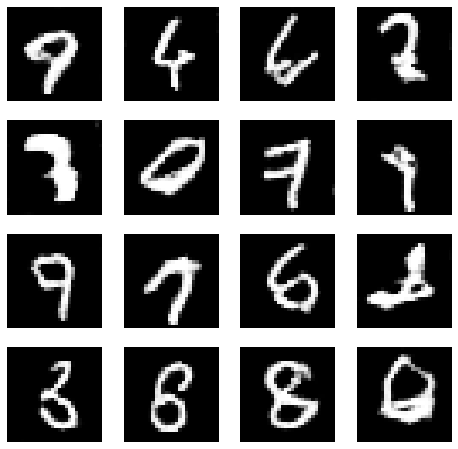

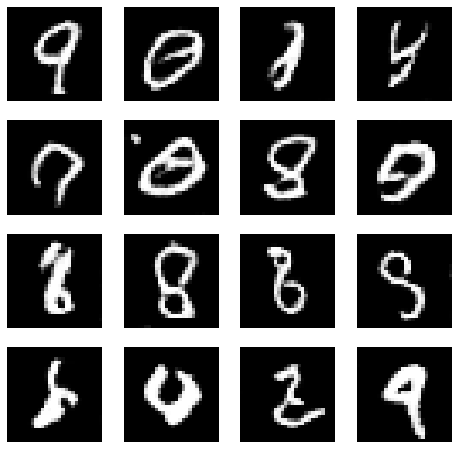

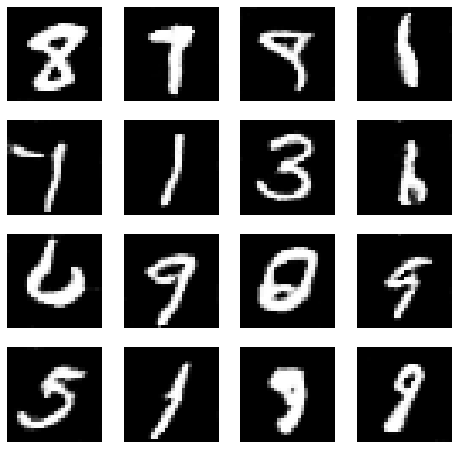

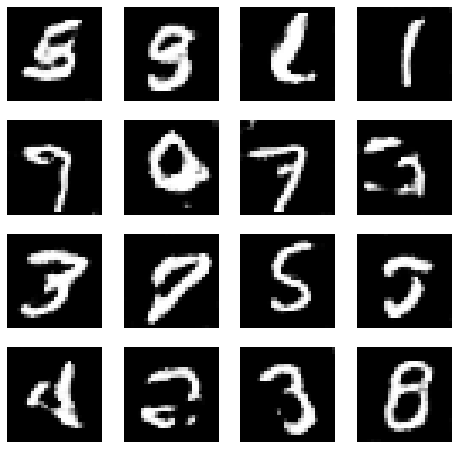

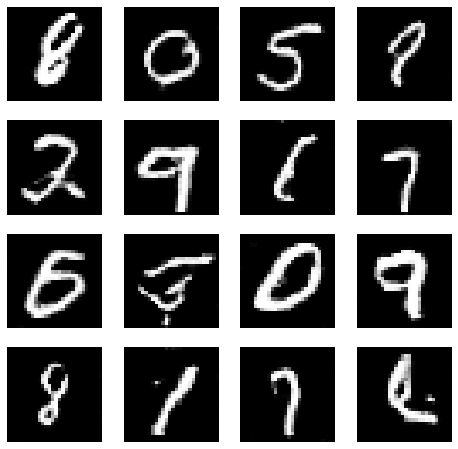

In [37]:
iterations = 8000
batch_size = 64
sample_interval = 800
train(iterations, batch_size, sample_interval)

In [23]:
GAN.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 28, 28, 1)         1637121   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 113930    
Total params: 1,751,051
Trainable params: 1,636,737
Non-trainable params: 114,314
_________________________________________________________________


In [38]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

_, accuracy = discriminator_supervised.evaluate(x, y)
print('Test Accuracy: {0}'.format(100 * accuracy))

10000/10000 [==============================] - 1s 76us/step
Test Accuracy: 98.17492961883545
